In [1]:
import pandas as pd          
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime    
from pandas import Series 
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline
plt.rcParams['font.sans-serif'] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False
import seaborn as sns

In [2]:
df = pd.read_csv("./示例数据/order_train0.csv")

In [3]:
df

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty
0,2015/9/2,104,20028,301,405,offline,1005.0,11
1,2015/9/3,102,20354,303,401,offline,1420.0,64
2,2015/9/4,101,20586,306,407,offline,978.0,7
3,2015/9/4,101,20230,306,407,offline,864.0,66
4,2015/9/4,105,21619,306,402,online,274.0,102
...,...,...,...,...,...,...,...,...
59764,2018/12/20,103,20337,302,408,offline,799.0,2
59765,2018/12/20,103,20146,306,402,offline,327.0,87
59766,2018/12/20,103,21911,306,407,offline,1006.0,2
59767,2018/12/20,102,21195,302,408,offline,1855.0,134


In [3]:
df_0 = df

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59769 entries, 0 to 59768
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   order_date         59769 non-null  object 
 1   sales_region_code  59769 non-null  int64  
 2   item_code          59769 non-null  int64  
 3   first_cate_code    59769 non-null  int64  
 4   second_cate_code   59769 non-null  int64  
 5   sales_chan_name    59769 non-null  object 
 6   item_price         59769 non-null  float64
 7   ord_qty            59769 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 3.6+ MB


In [5]:
df.describe()

,sales_region_code,item_code,first_cate_code,second_cate_code,item_price,ord_qty
count,59769.000000,59769.000000,59769.000000,59769.000000,59769.000000,59769.000000
mean,102.895581,21005.448560,304.937325,406.440295,1074.334474,91.443139
std,1.500799,592.082875,2.007037,3.107452,966.881714,195.407986
min,101.000000,20001.000000,301.000000,401.000000,1.000000,1.000000
25%,102.000000,20512.000000,303.000000,404.000000,597.000000,10.000000
50%,103.000000,20973.000000,306.000000,407.000000,880.280000,29.000000
75%,105.000000,21518.000000,306.000000,408.000000,1291.000000,101.000000
max,105.000000,22084.000000,308.000000,412.000000,47911.000000,12480.000000


异常处理

<AxesSubplot: >

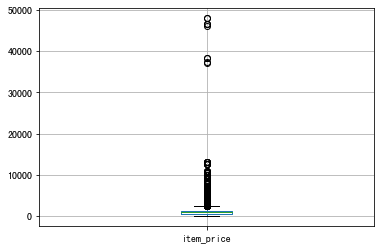

In [6]:
df.boxplot(column='item_price')

<AxesSubplot: >

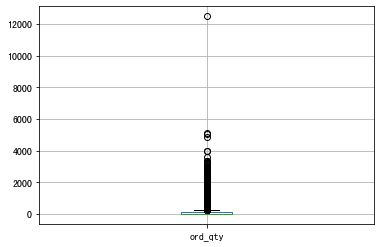

In [7]:
df.boxplot(column='ord_qty')

In [8]:
df.columns

Index(['order_date', 'sales_region_code', 'item_code', 'first_cate_code',
       'second_cate_code', 'sales_chan_name', 'item_price', 'ord_qty'],
      dtype='object')

In [9]:
def KsNormDetect(df):   # 输出结果是服从正态分布的数据列的名字
    from scipy.stats import kstest 
    list_norm_T = []   # 用来储存服从正态分布的数据列的名字
    for col in df.columns:
        u = df[col].mean()               # 计算均值
        std = df[col].std()              # 计算标准差
        res=kstest(df[col], 'norm', (u, std))[1]  # 计算P值
        if res<=0.05:                        # 判断p值是否服从正态分布，p<=0.05 则服从正态分布，否则不服从
            print(f'{col}该列数据服从正态分布------')
            print('均值为：%.3f，标准差为：%.3f' % (u, std))
            print('-'*40)
            list_norm_T.append(col)             
        else:                                # 这一段实际上没什么必要
            print(f'!!!{col}该列数据不服从正态分布**********')
            print('均值为：%.3f，标准差为：%.3f' % (u, std))
            print('*'*40)
KsNormDetect(df[['item_price', 'ord_qty']])

item_price该列数据服从正态分布------
均值为：1074.334，标准差为：966.882
----------------------------------------
ord_qty该列数据服从正态分布------
均值为：91.443，标准差为：195.408
----------------------------------------


In [10]:
# 对待处理数据中心服从正态分布的数据列
def three_sigma(Ser1):  # Ser1：表示传入DataFrame的某一列
    rule = []
    rule = (Ser1.mean()-3*Ser1.std()>Ser1) | (Ser1.mean()+3*Ser1.std()< Ser1)
    out = Ser1.index[rule]
    print(len(out))
    return out          # 返回落在3sigma之外的行索引值

def delete_out3sigma(data, list_norm):  # data：待检测的DataFrame；list_norm：服从正态分布的数据列名 
    out_index = []                      # 保存要删除的行索引
    for col in list_norm:            # 对每一列分别用3sigma原则处理
        index = three_sigma(data[col])
        out_index += index.tolist()
    delete_ = list(set(out_index))  # 去除 out_index 中的重复元素
    print(f'\n所删除的行索引共计{len(delete_)}个：\n',delete_)
    data.drop(delete_,inplace=True) # 根据 delete_ 删除对应行的数据
    df = data
    return df

delete_out3sigma(df,['item_price','ord_qty'])

616
1049

所删除的行索引共计1665个：
 [9, 10, 24586, 8206, 40978, 25, 57377, 39, 57390, 51, 24628, 32823, 16446, 24638, 24639, 16449, 41029, 16458, 41036, 49230, 16465, 41061, 16490, 8302, 49263, 32908, 49294, 24748, 32951, 57531, 41149, 24771, 32964, 32965, 16584, 57544, 49357, 8398, 207, 49365, 33019, 24839, 41224, 24842, 41227, 24844, 24847, 8469, 33052, 57630, 33055, 33057, 292, 16676, 41270, 41273, 33081, 49481, 24905, 334, 33102, 33103, 33113, 33123, 33125, 33128, 24940, 33143, 33144, 8572, 8573, 16764, 41343, 8585, 41357, 33167, 24978, 8601, 57753, 57754, 24989, 33193, 57770, 49579, 57772, 33197, 16816, 8629, 33207, 57798, 16840, 16841, 33228, 33232, 466, 16852, 16857, 33241, 33242, 57821, 16863, 25057, 488, 33257, 33276, 57853, 8705, 57858, 520, 57872, 49682, 49683, 25108, 33299, 41495, 25113, 546, 41507, 57893, 16934, 33321, 57899, 33324, 16943, 562, 33333, 567, 571, 573, 575, 577, 49729, 49734, 586, 57932, 25171, 8791, 16985, 605, 49758, 8800, 57963, 41582, 33402, 635, 637, 33408, 644, 

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty
0,2015/9/2,104,20028,301,405,offline,1005.0,11
1,2015/9/3,102,20354,303,401,offline,1420.0,64
2,2015/9/4,101,20586,306,407,offline,978.0,7
3,2015/9/4,101,20230,306,407,offline,864.0,66
4,2015/9/4,105,21619,306,402,online,274.0,102
...,...,...,...,...,...,...,...,...
59764,2018/12/20,103,20337,302,408,offline,799.0,2
59765,2018/12/20,103,20146,306,402,offline,327.0,87
59766,2018/12/20,103,21911,306,407,offline,1006.0,2
59767,2018/12/20,102,21195,302,408,offline,1855.0,134


In [11]:
df.describe()

,sales_region_code,item_code,first_cate_code,second_cate_code,item_price,ord_qty
count,58104.000000,58104.000000,58104.000000,58104.000000,58104.000000,58104.000000
mean,102.899026,21003.224563,304.941312,406.441828,1027.245243,73.399060
std,1.501404,592.988239,2.010454,3.099938,624.321995,107.953254
min,101.000000,20001.000000,301.000000,401.000000,1.000000,1.000000
25%,102.000000,20504.000000,303.000000,404.000000,600.000000,10.000000
50%,103.000000,20973.000000,306.000000,407.000000,881.000000,28.000000
75%,105.000000,21518.000000,306.000000,408.000000,1278.000000,93.000000
max,105.000000,22084.000000,308.000000,412.000000,3969.000000,677.000000


<AxesSubplot: >

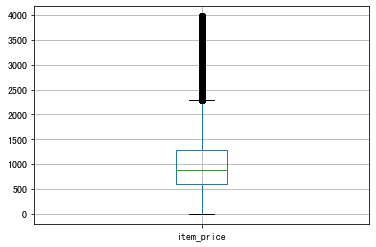

In [15]:
df.boxplot(column='item_price')

<AxesSubplot: >

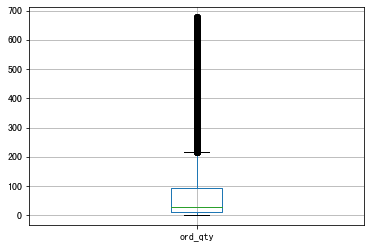

In [16]:
df.boxplot(column='ord_qty')

In [17]:
df_item = np.unique(df["item_code"],return_counts=True)
df_item

(array([20001, 20002, 20003, ..., 22082, 22083, 22084]),
 array([  2,  73, 283, ...,  15,  30,  57]))

In [5]:
df["item_code"].value_counts().sort_values()
#1423个商品

21271    864
20973    790
21619    633
20501    532
20283    487
        ... 
21591      1
20377      1
21576      1
20409      1
20598      1
Name: item_code, Length: 1423, dtype: int64

In [19]:
df["first_cate_code"].unique()

array([301, 303, 306, 305, 302, 307, 308, 304])

In [20]:
df["second_cate_code"].unique()

array([405, 401, 407, 402, 412, 408, 403, 410, 404, 409, 406, 411])

In [21]:
df["sales_region_code"].unique()

array([104, 102, 101, 105, 103])

In [22]:
df_region = df.groupby('sales_region_code')
df_region

In [23]:
df.head()

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty
0,2015/9/2,104,20028,301,405,offline,1005.0,11
1,2015/9/3,102,20354,303,401,offline,1420.0,64
2,2015/9/4,101,20586,306,407,offline,978.0,7
3,2015/9/4,101,20230,306,407,offline,864.0,66
4,2015/9/4,105,21619,306,402,online,274.0,102


In [24]:
df["order_date"]=df["order_date"].apply(pd.to_datetime,format='%Y-%m-%d')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58104 entries, 0 to 59768
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   order_date         58104 non-null  datetime64[ns]
 1   sales_region_code  58104 non-null  int64         
 2   item_code          58104 non-null  int64         
 3   first_cate_code    58104 non-null  int64         
 4   second_cate_code   58104 non-null  int64         
 5   sales_chan_name    58104 non-null  object        
 6   item_price         58104 non-null  float64       
 7   ord_qty            58104 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 4.0+ MB


In [26]:
dic = {"offline":1,"online":0}
df['sales_chan_name'] = df['sales_chan_name'].map(dic)

In [27]:
df.head()

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty
0,2015-09-02,104,20028,301,405,1,1005.0,11
1,2015-09-03,102,20354,303,401,1,1420.0,64
2,2015-09-04,101,20586,306,407,1,978.0,7
3,2015-09-04,101,20230,306,407,1,864.0,66
4,2015-09-04,105,21619,306,402,0,274.0,102


对日期时间进行时间特征处理，而时间特征包括年、季度、月、周、天(一年、一月、一周的第几天)

时间戳衍生中，另一常用的方法为布尔特征，即：

    是否年初/年末

    是否月初/月末

    是否周末

    是否节假日

    是否特殊日期

    是否早上/中午/晚上

In [28]:
pip install chinesecalendar

Note: you may need to restart the kernel to use updated packages.


In [29]:
import chinese_calendar

In [40]:
df['Year'] = df.order_date.dt.year
df['Month'] = df.order_date.dt.month
df['day'] = df.order_date.dt.day

df["day of the week"] = df.order_date.dt.dayofweek 
#是否周末
def applyer(df_row):
    if df_row.dayofweek ==5 or df_row.dayofweek ==6:
        return 1
    else:
        return 0
temp1 = df["order_date"]
temp2 = df.order_date.apply(applyer)
temp2["weekend"] = temp2
df.index = df["order_date"]

In [43]:
df["quarter"] = df['order_date'].dt.quarter
df['is_month_start'] = df['order_date'].dt.is_month_start
df['is_month_end'] = df['order_date'].dt.is_month_end
df['is_quarter_start'] = df['order_date'].dt.is_quarter_start
df['is_quarter_end'] = df['order_date'].dt.is_quarter_end
df['is_year_start'] = df['order_date'].dt.is_year_start
df['is_year_end'] = df['order_date'].dt.is_year_end
df['is_workday']=df['order_date'].map(lambda x:chinese_calendar.is_workday(x))
df["is_holiday"]=df["order_date"].map(lambda x:chinese_calendar.is_holiday(x))

In [44]:
for u in df.columns:
    if df[u].dtype==bool:
        df[u]=df[u].astype('int')
df

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty,Year,Month,...,day of the week,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_workday,is_holiday
order_date,,,,,,,,,,,,,,,,,,,,,
2015-09-02,2015-09-02,104,20028,301,405,1,1005.0,11,2015,9,...,2,3,0,0,0,0,0,0,1,0
2015-09-03,2015-09-03,102,20354,303,401,1,1420.0,64,2015,9,...,3,3,0,0,0,0,0,0,0,1
2015-09-04,2015-09-04,101,20586,306,407,1,978.0,7,2015,9,...,4,3,0,0,0,0,0,0,0,1
2015-09-04,2015-09-04,101,20230,306,407,1,864.0,66,2015,9,...,4,3,0,0,0,0,0,0,0,1
2015-09-04,2015-09-04,105,21619,306,402,0,274.0,102,2015,9,...,4,3,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-20,2018-12-20,103,20337,302,408,1,799.0,2,2018,12,...,3,4,0,0,0,0,0,0,1,0
2018-12-20,2018-12-20,103,20146,306,402,1,327.0,87,2018,12,...,3,4,0,0,0,0,0,0,1,0
2018-12-20,2018-12-20,103,21911,306,407,1,1006.0,2,2018,12,...,3,4,0,0,0,0,0,0,1,0


In [45]:
df["sales"] = (df["ord_qty"])*(df["item_price"])
df.columns

Index(['order_date', 'sales_region_code', 'item_code', 'first_cate_code',
       'second_cate_code', 'sales_chan_name', 'item_price', 'ord_qty', 'Year',
       'Month', 'day', 'day of the week', 'quarter', 'is_month_start',
       'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start',
       'is_year_end', 'is_workday', 'is_holiday', 'sales'],
      dtype='object')

In [46]:
df.to_csv("df_sales_.csv")

# 数据探索

In [47]:
sales_data = df

In [48]:
sales_data.columns

Index(['order_date', 'sales_region_code', 'item_code', 'first_cate_code',
       'second_cate_code', 'sales_chan_name', 'item_price', 'ord_qty', 'Year',
       'Month', 'day', 'day of the week', 'quarter', 'is_month_start',
       'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start',
       'is_year_end', 'is_workday', 'is_holiday', 'sales'],
      dtype='object')

In [49]:
sales_data["sales_region_code"].unique()

array([104, 102, 101, 105, 103])

In [ ]:
#dic = {""}
#sales_data['sales_region_code'] = sales_data['sales_region_code'].map(dic)

In [34]:
quantitative_variable = ["ord_qty","item_price","sales"]
sales_data[quantitative_variable].describe()

,ord_qty,item_price,sales
count,58104.000000,58104.000000,5.810400e+04
mean,73.399060,1027.245243,5.928960e+04
std,107.953254,624.321995,8.832603e+04
min,1.000000,1.000000,4.000000e+00
25%,10.000000,600.000000,1.007100e+04
50%,28.000000,881.000000,2.665600e+04
75%,93.000000,1278.000000,6.941250e+04
max,677.000000,3969.000000,1.548015e+06


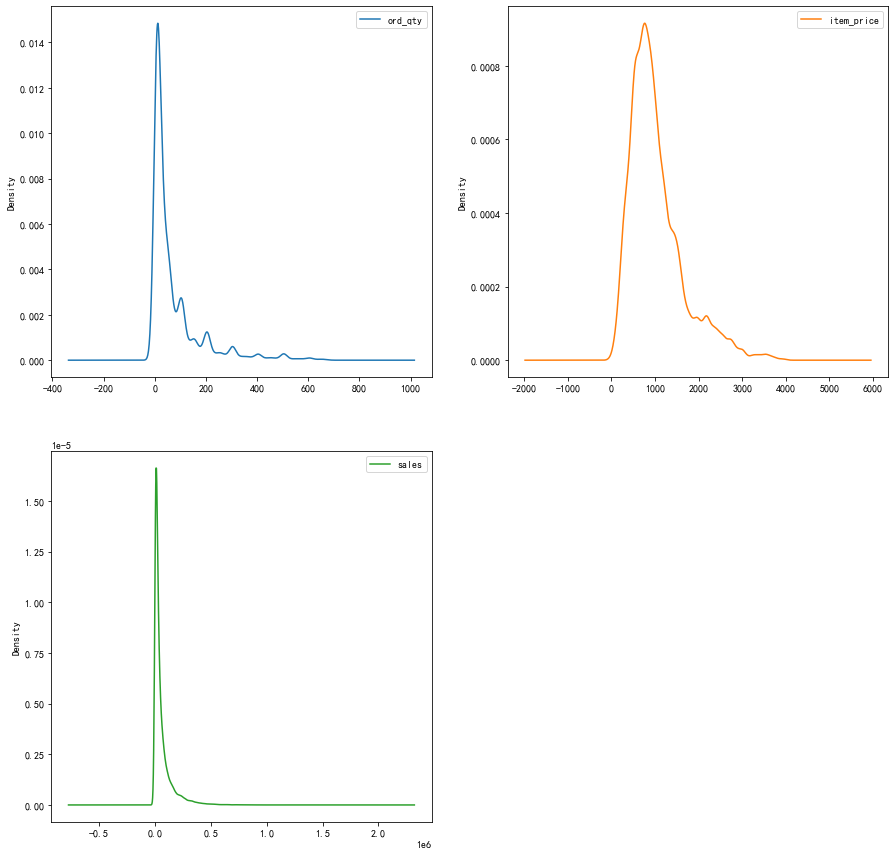

In [35]:
sales_data[quantitative_variable].plot(kind='density', subplots=True, sharex=False, sharey=False, layout=(2,2),figsize=(15,15))
plt.show()

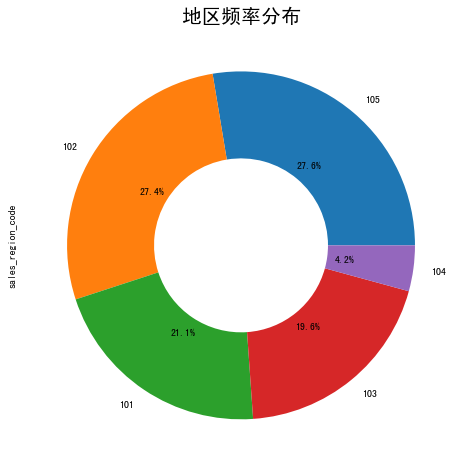

In [50]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ["SimHei"]
matplotlib.rcParams["axes.unicode_minus"] = False
#频率分布
region = sales_data["sales_region_code"].value_counts(normalize = True,)
plt.figure(figsize=(16,8))
region.plot(kind= 'pie', autopct='%1.1f%%',wedgeprops = {"width":0.5})
plt.title("地区频率分布",fontsize=20)
plt.show()

In [37]:
sales_data.columns

Index(['order_date', 'sales_region_code', 'item_code', 'first_cate_code',
       'second_cate_code', 'sales_chan_name', 'item_price', 'ord_qty', 'Year',
       'Month', 'day', 'day of the week', 'quarter', 'is_month_start',
       'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start',
       'is_year_end', 'is_workday', 'is_holiday', 'sales'],
      dtype='object')

In [38]:
sales_data['year'] = sales_data['order_date'].dt.year
sales_data['month'] = sales_data['order_date'].dt.month
sales_data['day'] = sales_data["order_date"].dt.day

,item_code,item_price,ord_qty,sales,year,month,day
count,52940.000000,52940.000000,52940.000000,52940.000000,52940.000000,52940.000000,52940.000000
mean,21001.934794,990.282028,51.951096,44508.041944,2017.009275,7.073385,16.936532
std,594.912502,532.303085,60.099462,55921.612389,0.919886,3.500559,8.388459
min,20001.000000,1.000000,1.000000,4.000000,2015.000000,1.000000,1.000000
25%,20501.000000,606.000000,10.000000,9226.000000,2016.000000,4.000000,10.000000
50%,20973.000000,886.000000,26.000000,23517.000000,2017.000000,8.000000,17.000000
75%,21521.000000,1259.000000,69.000000,57885.500000,2018.000000,10.000000,24.000000
max,22084.000000,2685.380000,288.000000,710782.000000,2018.000000,12.000000,31.000000


In [39]:
#时间
sales_data.groupby(['year'])['month'].nunique()

year
2015     4
2016    12
2017    12
2018    12
Name: month, dtype: int64

可以看出上述信息不完整，月度信息将进行进一步分析

# 提醒：
**下方的一些分析，可以根据'quarter', 'is_month_start','is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start','is_year_end', 'is_workday', 'is_holiday',更换，下方我只展示了一部分**


**根据情况对groupby里的变量进行更换即可，绘图时对应更改x,y,hue即可**

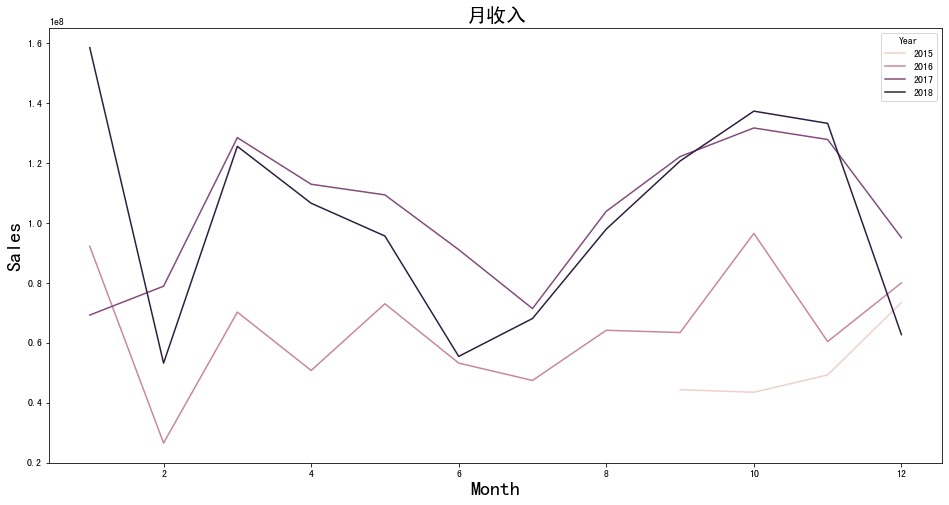

In [51]:
#月收入状况
plt.figure(figsize=(16,8))

monthly_revenue = sales_data.groupby(['Year','Month'])['sales'].sum().reset_index()
sns.lineplot(x="Month", y="sales",hue="Year", data = monthly_revenue)
plt.xlabel('Month',fontsize = 20)
plt.ylabel('Sales',fontsize = 20)
plt.title('月收入',fontsize = 20)
plt.show()

数据显示，2016年，2017年的销售额在10月左右达到峰值，1、3月份也有大幅度回升，2018年在1月达到最大值，3月、10月也有大幅度回升。
这可能是因为当时有许多庆祝活动和节日（感恩节、万圣节、国庆节、春节等）。

我们没有足够的2015年数据，但现有数据显示

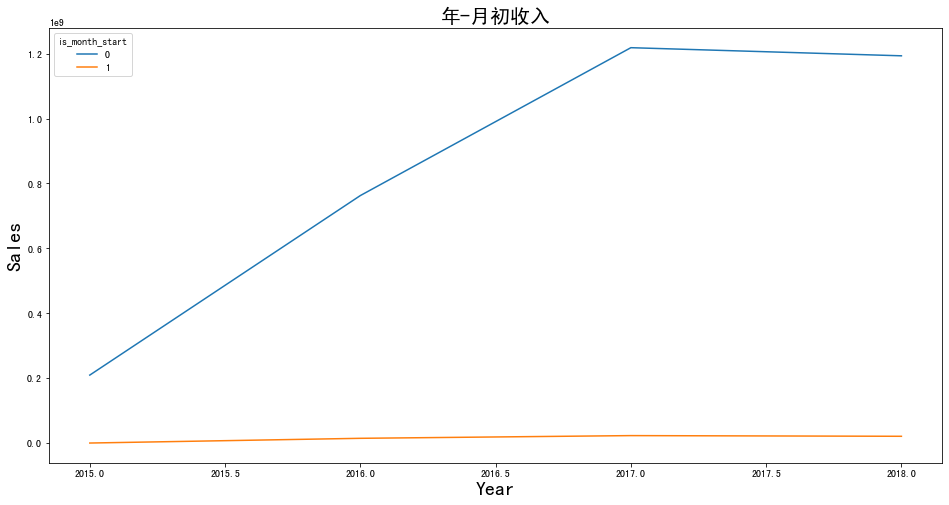

In [52]:
plt.figure(figsize=(16,8))

monthly_revenue = sales_data.groupby(['is_month_start','Year'])['sales'].sum().reset_index()
sns.lineplot(x="Year", y="sales",hue="is_month_start", data = monthly_revenue)
plt.xlabel('Year',fontsize = 20)
plt.ylabel('Sales',fontsize = 20)
plt.title('年-月初收入',fontsize = 20)
plt.show()

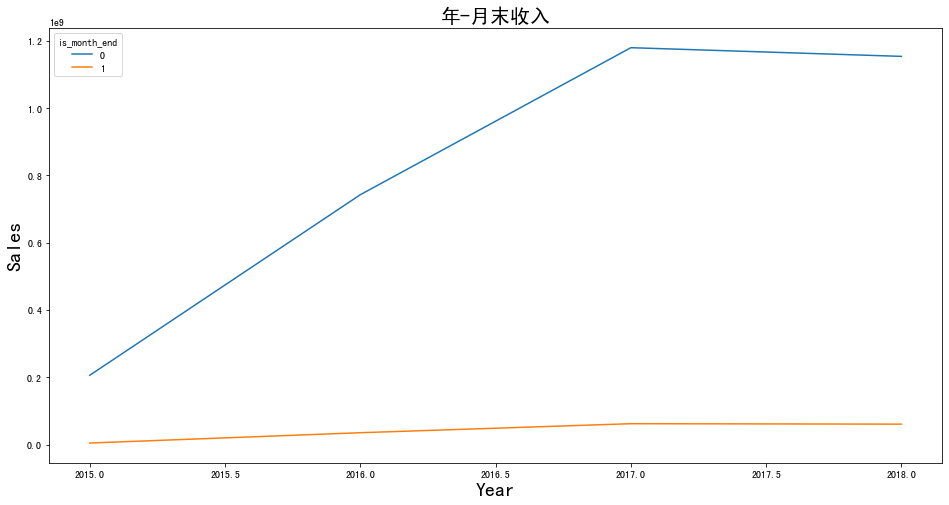

In [53]:
plt.figure(figsize=(16,8))

monthly_revenue = sales_data.groupby(['is_month_end','Year'])['sales'].sum().reset_index()
sns.lineplot(x="Year", y="sales",hue="is_month_end", data = monthly_revenue)
plt.xlabel('Year',fontsize = 20)
plt.ylabel('Sales',fontsize = 20)
plt.title('年-月末收入',fontsize = 20)
plt.show()

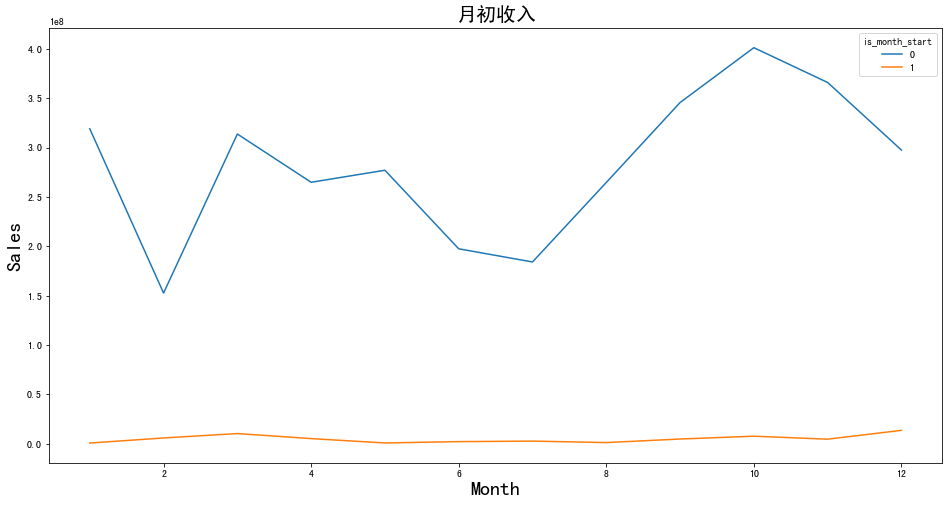

In [54]:
plt.figure(figsize=(16,8))

monthly_revenue = sales_data.groupby(['is_month_start','Month'])['sales'].sum().reset_index()
sns.lineplot(x="Month", y="sales",hue="is_month_start", data = monthly_revenue)
plt.xlabel('Month',fontsize = 20)
plt.ylabel('Sales',fontsize = 20)
plt.title('月初收入',fontsize = 20)
plt.show()

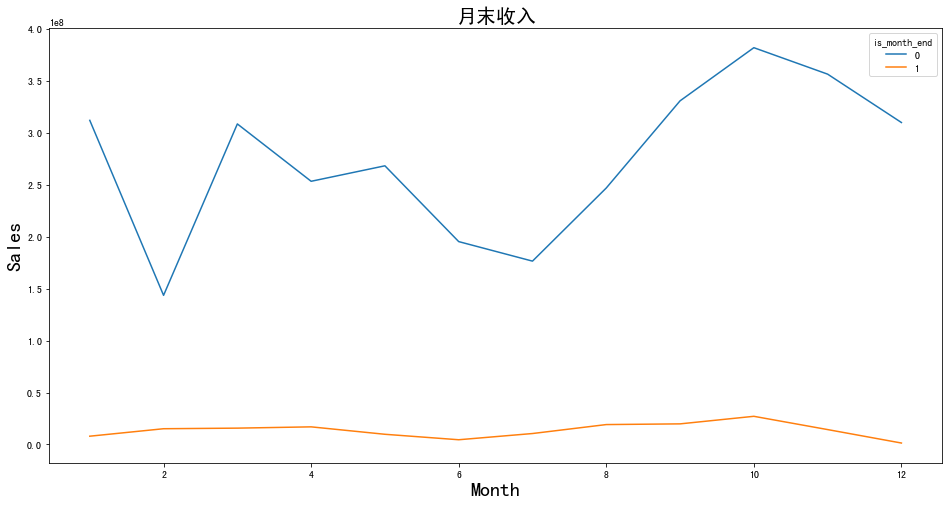

In [55]:
plt.figure(figsize=(16,8))

monthly_revenue = sales_data.groupby(['is_month_end','Month'])['sales'].sum().reset_index()
sns.lineplot(x="Month", y="sales",hue="is_month_end", data = monthly_revenue)
plt.xlabel('Month',fontsize = 20)
plt.ylabel('Sales',fontsize = 20)
plt.title('月末收入',fontsize = 20)
plt.show()

/Users/xuan/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[]

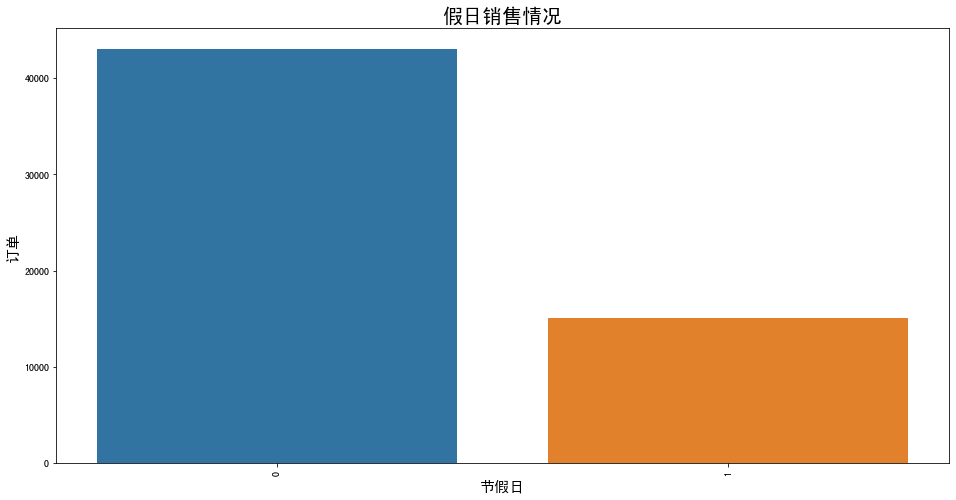

In [56]:
#节假日销售情况
plt.figure(figsize=(16,8))
sns.countplot(sales_data['is_holiday'])
plt.title('假日销售情况',fontsize = 20)
plt.xticks(np.arange(0,7),np.arange(0,7),rotation=90)
plt.xlabel('节假日',fontsize = 15)
plt.ylabel('订单',fontsize = 15)
plt.plot()

/Users/xuan/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[]

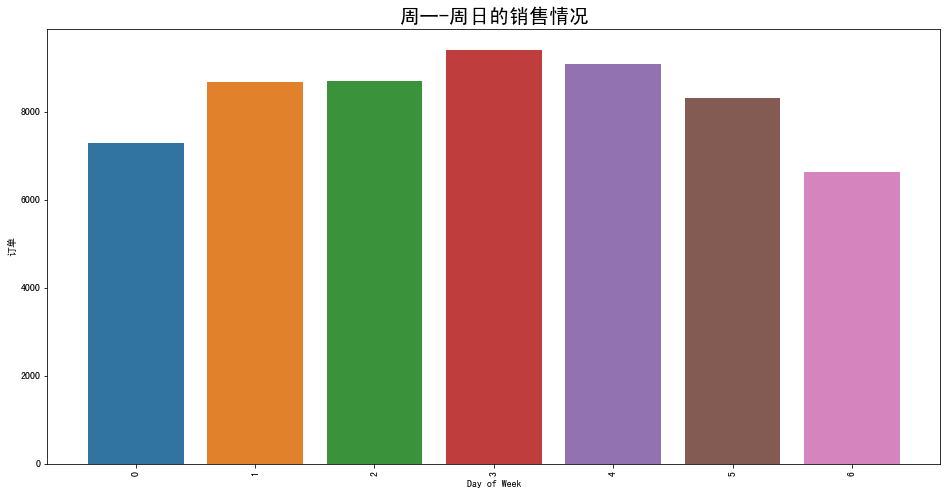

In [57]:
sales_data['order_date'].dt.dayofweek
plt.figure(figsize=(16,8))
sns.countplot(sales_data['day of the week'])
plt.title('周一-周日的销售情况',fontsize = 20)
plt.xticks(np.arange(0,7),np.arange(0,7),rotation=90)
plt.xlabel('Day of Week')
plt.ylabel('订单')
plt.plot()

大多数销售发生在周四，紧随其后的是周五，其次是周二、三。
因此，如果销售商打算有效地做广告，
以增加更多销售额的可能性，
那么他们应该在周二和周五之间做更多的广告，
因为他们有更多的客户流量。 

In [58]:
sales_data.columns

Index(['order_date', 'sales_region_code', 'item_code', 'first_cate_code',
       'second_cate_code', 'sales_chan_name', 'item_price', 'ord_qty', 'Year',
       'Month', 'day', 'day of the week', 'quarter', 'is_month_start',
       'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start',
       'is_year_end', 'is_workday', 'is_holiday', 'sales'],
      dtype='object')

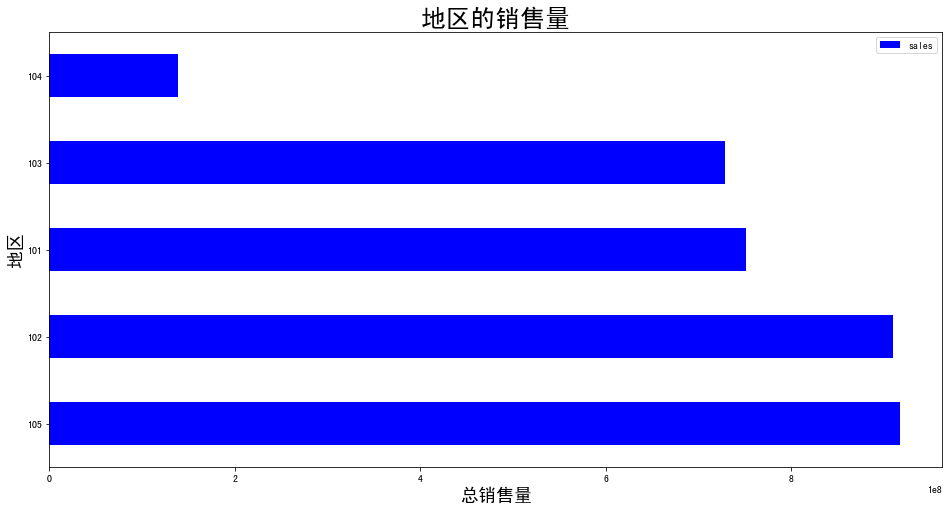

In [59]:
#销售品牌分析
plt.figure(figsize=(16,8))
sales_per_product = sales_data.groupby(['sales_region_code'])['sales'].sum().sort_values(ascending=False)
sales_per_product.plot(kind = 'barh', color='blue')
plt.title('地区的销售量',fontsize=25)
plt.xlabel('总销售量',fontsize = 18)
plt.ylabel('地区',fontsize = 18)
plt.legend()
plt.show()

可以看出地区销售量状况中，105销售最多，其次是102,101,103,1104

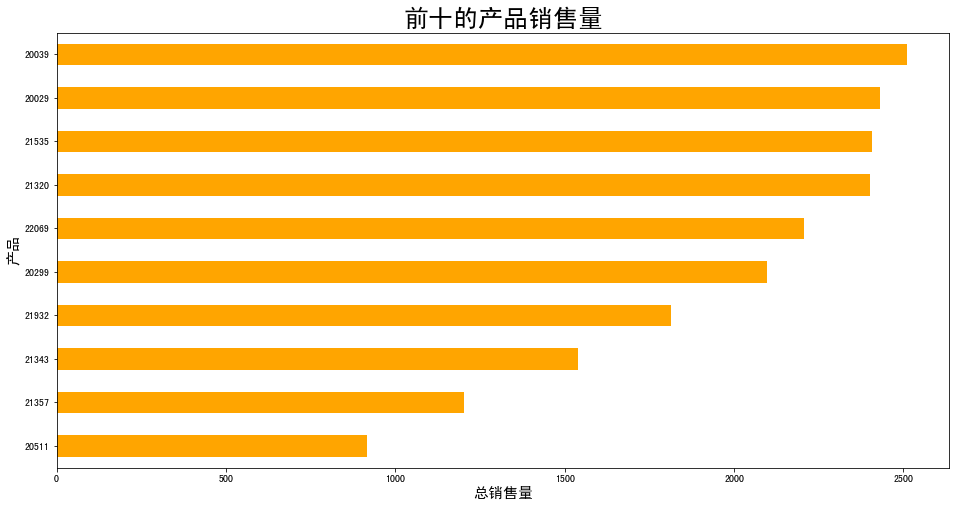

In [60]:
plt.figure(figsize=(16,8))
sales_per_item = sales_data.groupby(['item_code'])['sales'].sum().sort_values(ascending=True)
sales_per_item[:10].plot(kind = 'barh', color='orange')
plt.title('前十的产品销售量',fontsize = 25)
plt.xlabel('总销售量',fontsize = 15)
plt.ylabel('产品',fontsize = 15)
plt.show()

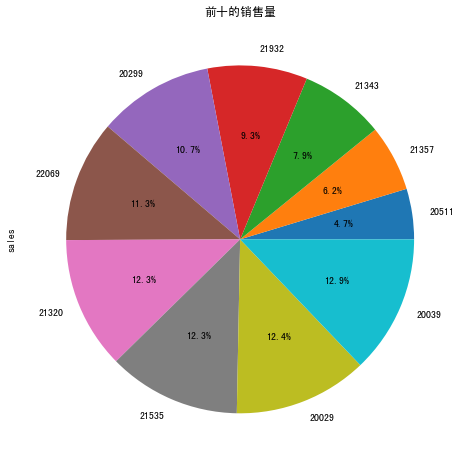

In [61]:
plt.figure(figsize=(16,8))
sales_per_item[:10].plot(kind= 'pie', autopct='%1.1f%%')
plt.title("前十的销售量")
plt.show()

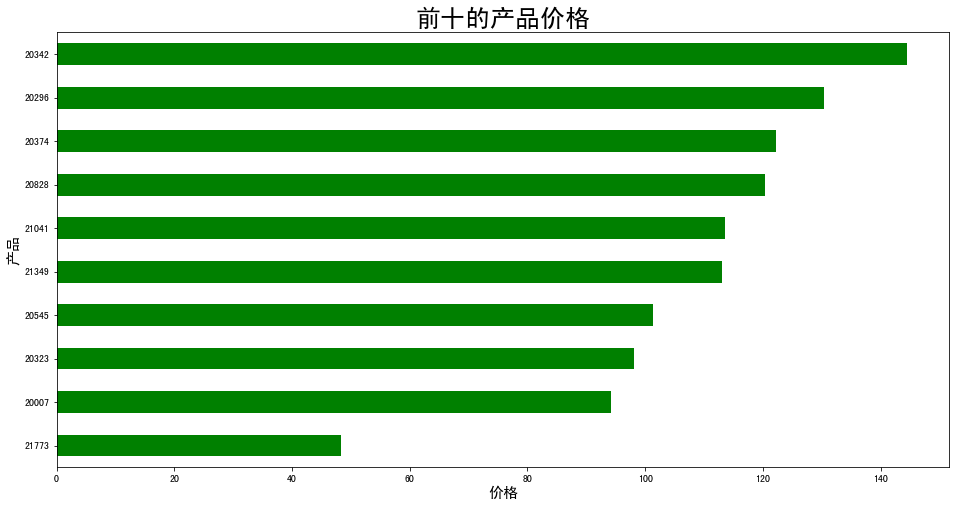

In [62]:
plt.figure(figsize=(16,8))
sales_per_price = sales_data.groupby(['item_code'])['item_price'].mean().sort_values(ascending=True)
sales_per_price[:10].plot(kind = 'barh', color='green')
plt.title('前十的产品价格',fontsize = 25)
plt.xlabel('价格',fontsize = 15)
plt.ylabel('产品',fontsize = 15)
plt.show()

In [70]:
sales_per_price_10 = sales_data.groupby(['item_code'])['item_price'].mean().sort_values(ascending=False)
sales_per_price_10.head(10)

item_code
20235    3962.384615
21793    3841.750000
21072    3803.500000
21438    3726.636364
20202    3708.363636
20735    3661.000000
20563    3624.111111
21261    3622.555556
21477    3542.925926
20245    3510.388889
Name: item_price, dtype: float64

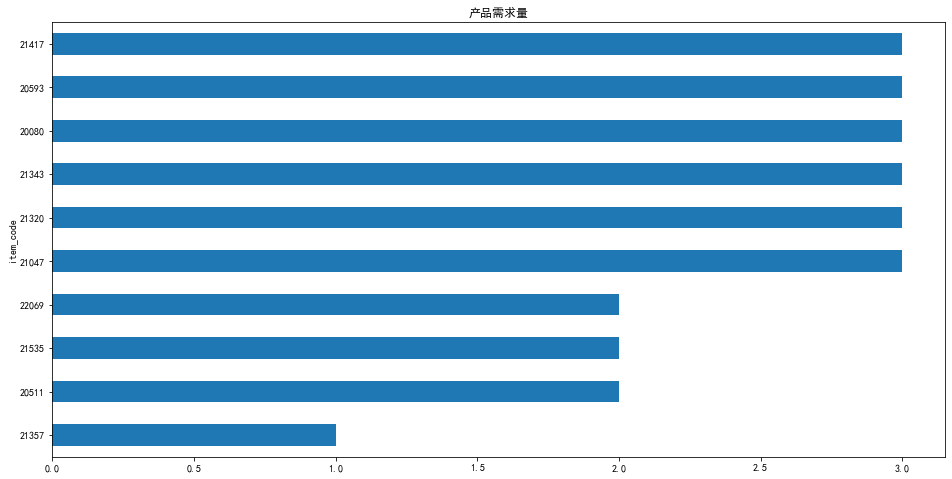

In [71]:
product_demand = sales_data.groupby(['item_code'])['ord_qty'].sum().sort_values(ascending=True)
plt.figure(figsize=(16,8))
product_demand[:10].plot(kind= 'barh')
plt.title("产品需求量")
plt.show()

In [72]:
product_demand[-10:].sort_values(ascending = False)

item_code
21271    139053
20973    111185
21619     82198
20283     57184
21394     57105
20996     54458
21061     50800
20501     47470
20457     38034
21601     36233
Name: ord_qty, dtype: int64

# 根据自己需要进行换，下面的操作后续也不太需要，根据个人需要进行

In [ ]:
####################################################################################

In [174]:
dic1 = {101:"地区1",102:"地区2",103:"地区3",104:"地区4",105:"地区5"}
dic2 = {301:"大类别1",302:"大类别2",303:"大类别3",304:"大类别4",305:"大类别5",306:"大类别6",307:"类别7",308:"大类别8"}
dic3 = {401:"细类别1",402:"细类别2",403:"细类别3",404:"细类别4",405:"细类别5",406:"细类别6",407:"细类别7",408:"细类别8",409:"细类别9",410:"细类别10",411:"细类别11",412:"细类别12"}
sales_data['sales_region_code'] = sales_data['sales_region_code'].map(dic1)
sales_data['first_cate_code'] = sales_data['first_cate_code'].map(dic2)
sales_data['second_cate_code'] = sales_data['second_cate_code'].map(dic3)

In [175]:
sales_data.shape

(58104, 22)

In [176]:
sales_data.head()

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty,Year,Month,...,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_workday,is_holiday,sales
order_date,,,,,,,,,,,,,,,,,,,,,
2015-09-02,2015-09-02,地区4,20028,大类别1,细类别5,1,1005.0,11,2015,9,...,3,0,0,0,0,0,0,1,0,11055.0
2015-09-03,2015-09-03,地区2,20354,大类别3,细类别1,1,1420.0,64,2015,9,...,3,0,0,0,0,0,0,0,1,90880.0
2015-09-04,2015-09-04,地区1,20586,大类别6,细类别7,1,978.0,7,2015,9,...,3,0,0,0,0,0,0,0,1,6846.0
2015-09-04,2015-09-04,地区1,20230,大类别6,细类别7,1,864.0,66,2015,9,...,3,0,0,0,0,0,0,0,1,57024.0
2015-09-04,2015-09-04,地区5,21619,大类别6,细类别2,0,274.0,102,2015,9,...,3,0,0,0,0,0,0,0,1,27948.0


In [ ]:
##########################################################################################

In [40]:
sales_data.to_csv("sales_data.csv")

In [41]:
sales_data

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty,Year,Month,...,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_workday,is_holiday,sales,year,month
order_date,,,,,,,,,,,,,,,,,,,,,
2015-09-02,2015-09-02,104,20028,301,405,1,1005.0,11,2015,9,...,0,0,0,0,0,1,0,11055.0,2015,9
2015-09-03,2015-09-03,102,20354,303,401,1,1420.0,64,2015,9,...,0,0,0,0,0,0,1,90880.0,2015,9
2015-09-04,2015-09-04,101,20586,306,407,1,978.0,7,2015,9,...,0,0,0,0,0,0,1,6846.0,2015,9
2015-09-04,2015-09-04,101,20230,306,407,1,864.0,66,2015,9,...,0,0,0,0,0,0,1,57024.0,2015,9
2015-09-04,2015-09-04,105,21619,306,402,0,274.0,102,2015,9,...,0,0,0,0,0,0,1,27948.0,2015,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-20,2018-12-20,103,20337,302,408,1,799.0,2,2018,12,...,0,0,0,0,0,1,0,1598.0,2018,12
2018-12-20,2018-12-20,103,20146,306,402,1,327.0,87,2018,12,...,0,0,0,0,0,1,0,28449.0,2018,12
2018-12-20,2018-12-20,103,21911,306,407,1,1006.0,2,2018,12,...,0,0,0,0,0,1,0,2012.0,2018,12


In [178]:
#热编码
sales_data_dummies = pd.get_dummies(sales_data[['sales_region_code', 'first_cate_code', 'second_cate_code','sales_chan_name']])
sales_data_dummies = sales_data_dummies.drop(["sales_chan_name"],axis=1)

In [179]:
sales_data_dummies.head()

,sales_region_code_地区1,sales_region_code_地区2,sales_region_code_地区3,sales_region_code_地区4,sales_region_code_地区5,first_cate_code_大类别1,first_cate_code_大类别2,first_cate_code_大类别3,first_cate_code_大类别4,first_cate_code_大类别5,...,second_cate_code_细类别11,second_cate_code_细类别12,second_cate_code_细类别2,second_cate_code_细类别3,second_cate_code_细类别4,second_cate_code_细类别5,second_cate_code_细类别6,second_cate_code_细类别7,second_cate_code_细类别8,second_cate_code_细类别9
order_date,,,,,,,,,,,,,,,,,,,,,
2015-09-02,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2015-09-03,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-09-04,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2015-09-04,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2015-09-04,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [180]:
sales_data_dummies.columns

Index(['sales_region_code_地区1', 'sales_region_code_地区2',
       'sales_region_code_地区3', 'sales_region_code_地区4',
       'sales_region_code_地区5', 'first_cate_code_大类别1', 'first_cate_code_大类别2',
       'first_cate_code_大类别3', 'first_cate_code_大类别4', 'first_cate_code_大类别5',
       'first_cate_code_大类别6', 'first_cate_code_大类别8', 'first_cate_code_类别7',
       'second_cate_code_细类别1', 'second_cate_code_细类别10',
       'second_cate_code_细类别11', 'second_cate_code_细类别12',
       'second_cate_code_细类别2', 'second_cate_code_细类别3',
       'second_cate_code_细类别4', 'second_cate_code_细类别5',
       'second_cate_code_细类别6', 'second_cate_code_细类别7',
       'second_cate_code_细类别8', 'second_cate_code_细类别9'],
      dtype='object')

In [181]:
sales_data_dummies.shape

(58104, 25)

In [182]:
#将热编码后的数据与原数据结合
n_sales_data = sales_data.join(sales_data_dummies)
n_sales_data.columns

Index(['order_date', 'sales_region_code', 'item_code', 'first_cate_code',
       'second_cate_code', 'sales_chan_name', 'item_price', 'ord_qty', 'Year',
       'Month', 'day', 'day of the week', 'quarter', 'is_month_start',
       'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start',
       'is_year_end', 'is_workday', 'is_holiday', 'sales',
       'sales_region_code_地区1', 'sales_region_code_地区2',
       'sales_region_code_地区3', 'sales_region_code_地区4',
       'sales_region_code_地区5', 'first_cate_code_大类别1', 'first_cate_code_大类别2',
       'first_cate_code_大类别3', 'first_cate_code_大类别4', 'first_cate_code_大类别5',
       'first_cate_code_大类别6', 'first_cate_code_大类别8', 'first_cate_code_类别7',
       'second_cate_code_细类别1', 'second_cate_code_细类别10',
       'second_cate_code_细类别11', 'second_cate_code_细类别12',
       'second_cate_code_细类别2', 'second_cate_code_细类别3',
       'second_cate_code_细类别4', 'second_cate_code_细类别5',
       'second_cate_code_细类别6', 'second_cate_code_细类别7',


In [186]:
new_sales_data = n_sales_data.drop(['sales_region_code', 'item_code', 'first_cate_code', 'second_cate_code'], axis=1)

In [187]:
new_sales_data

,order_date,sales_chan_name,item_price,ord_qty,Year,Month,day,day of the week,quarter,is_month_start,...,second_cate_code_细类别11,second_cate_code_细类别12,second_cate_code_细类别2,second_cate_code_细类别3,second_cate_code_细类别4,second_cate_code_细类别5,second_cate_code_细类别6,second_cate_code_细类别7,second_cate_code_细类别8,second_cate_code_细类别9
order_date,,,,,,,,,,,,,,,,,,,,,
2015-09-02,2015-09-02,1,1005.0,11,2015,9,2,2,3,0,...,0,0,0,0,0,1,0,0,0,0
2015-09-03,2015-09-03,1,1420.0,64,2015,9,3,3,3,0,...,0,0,0,0,0,0,0,0,0,0
2015-09-04,2015-09-04,1,978.0,7,2015,9,4,4,3,0,...,0,0,0,0,0,0,0,1,0,0
2015-09-04,2015-09-04,1,978.0,7,2015,9,4,4,3,0,...,0,0,0,0,0,0,0,1,0,0
2015-09-04,2015-09-04,1,978.0,7,2015,9,4,4,3,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-20,2018-12-20,1,1103.0,108,2018,12,20,3,4,0,...,0,0,0,0,0,0,0,0,1,0
2018-12-20,2018-12-20,1,1103.0,108,2018,12,20,3,4,0,...,0,0,1,0,0,0,0,0,0,0
2018-12-20,2018-12-20,1,1103.0,108,2018,12,20,3,4,0,...,0,0,0,0,0,0,0,1,0,0


In [185]:
new_sales_data.shape

(3625956, 42)

<AxesSubplot:>

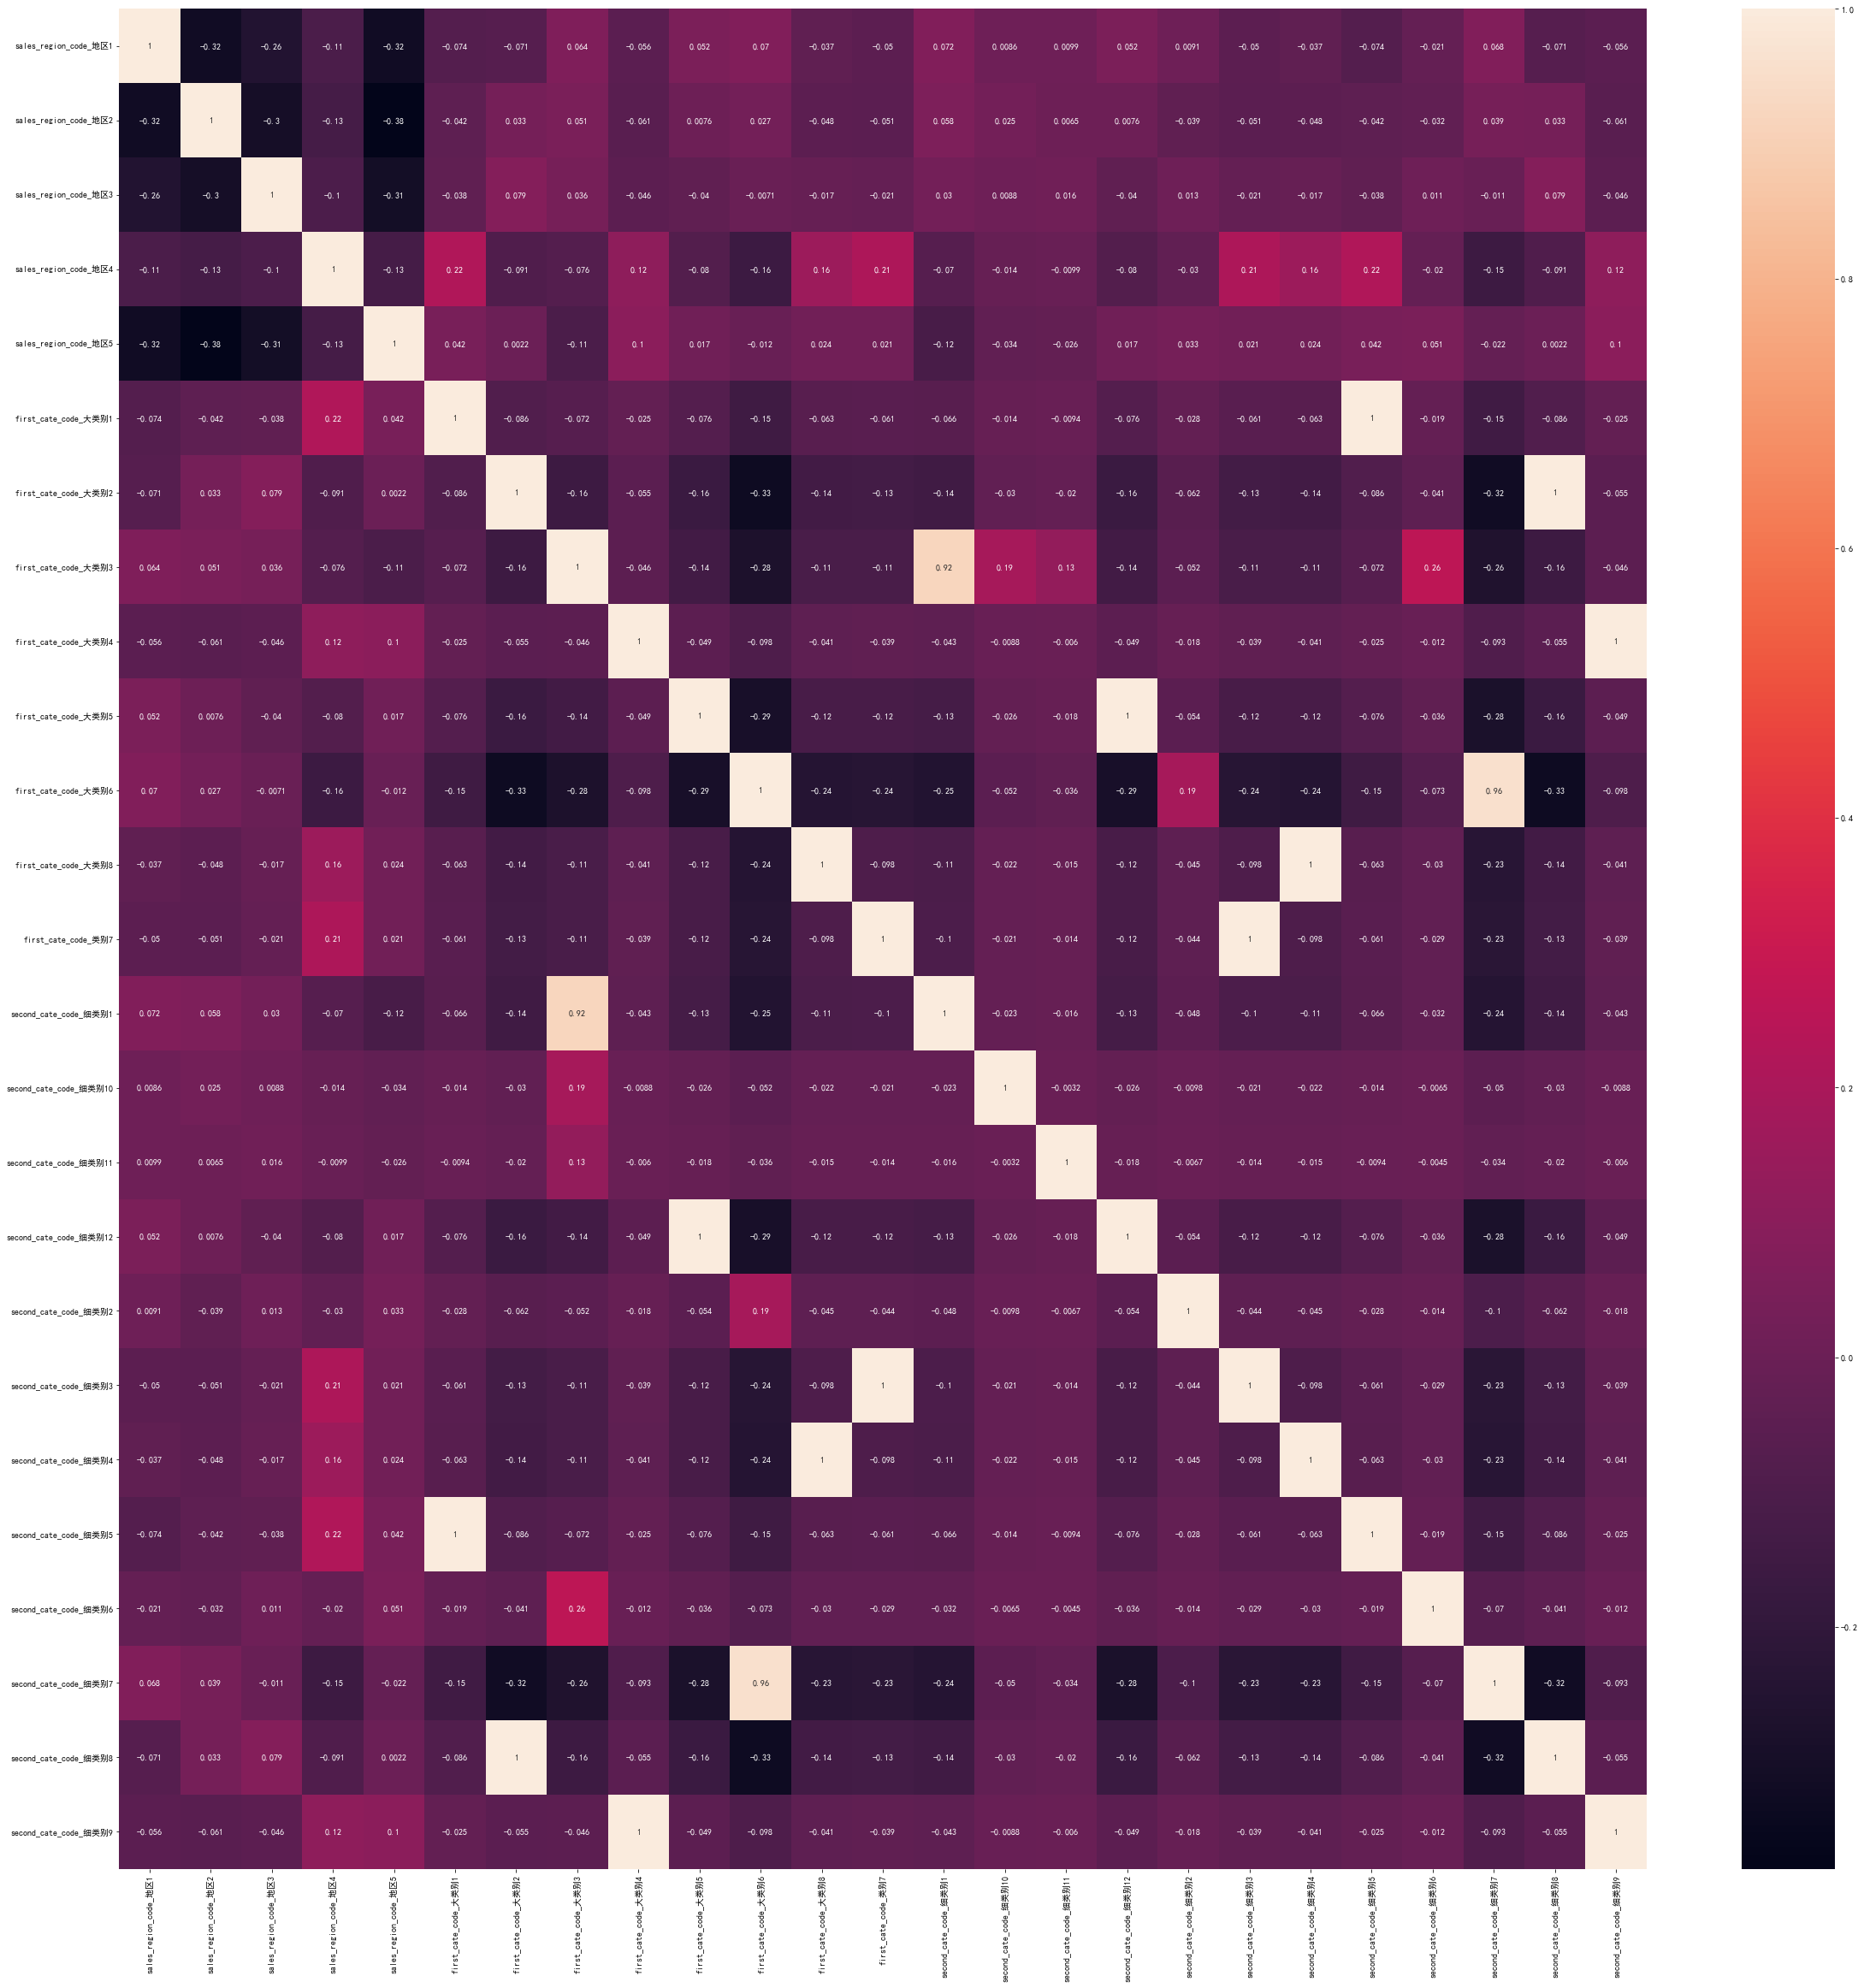

In [116]:
plt.figure(figsize = (40,40))
corr_matrix = sales_data_dummies.corr()
sns.heatmap(corr_matrix, annot = True)

<AxesSubplot:>

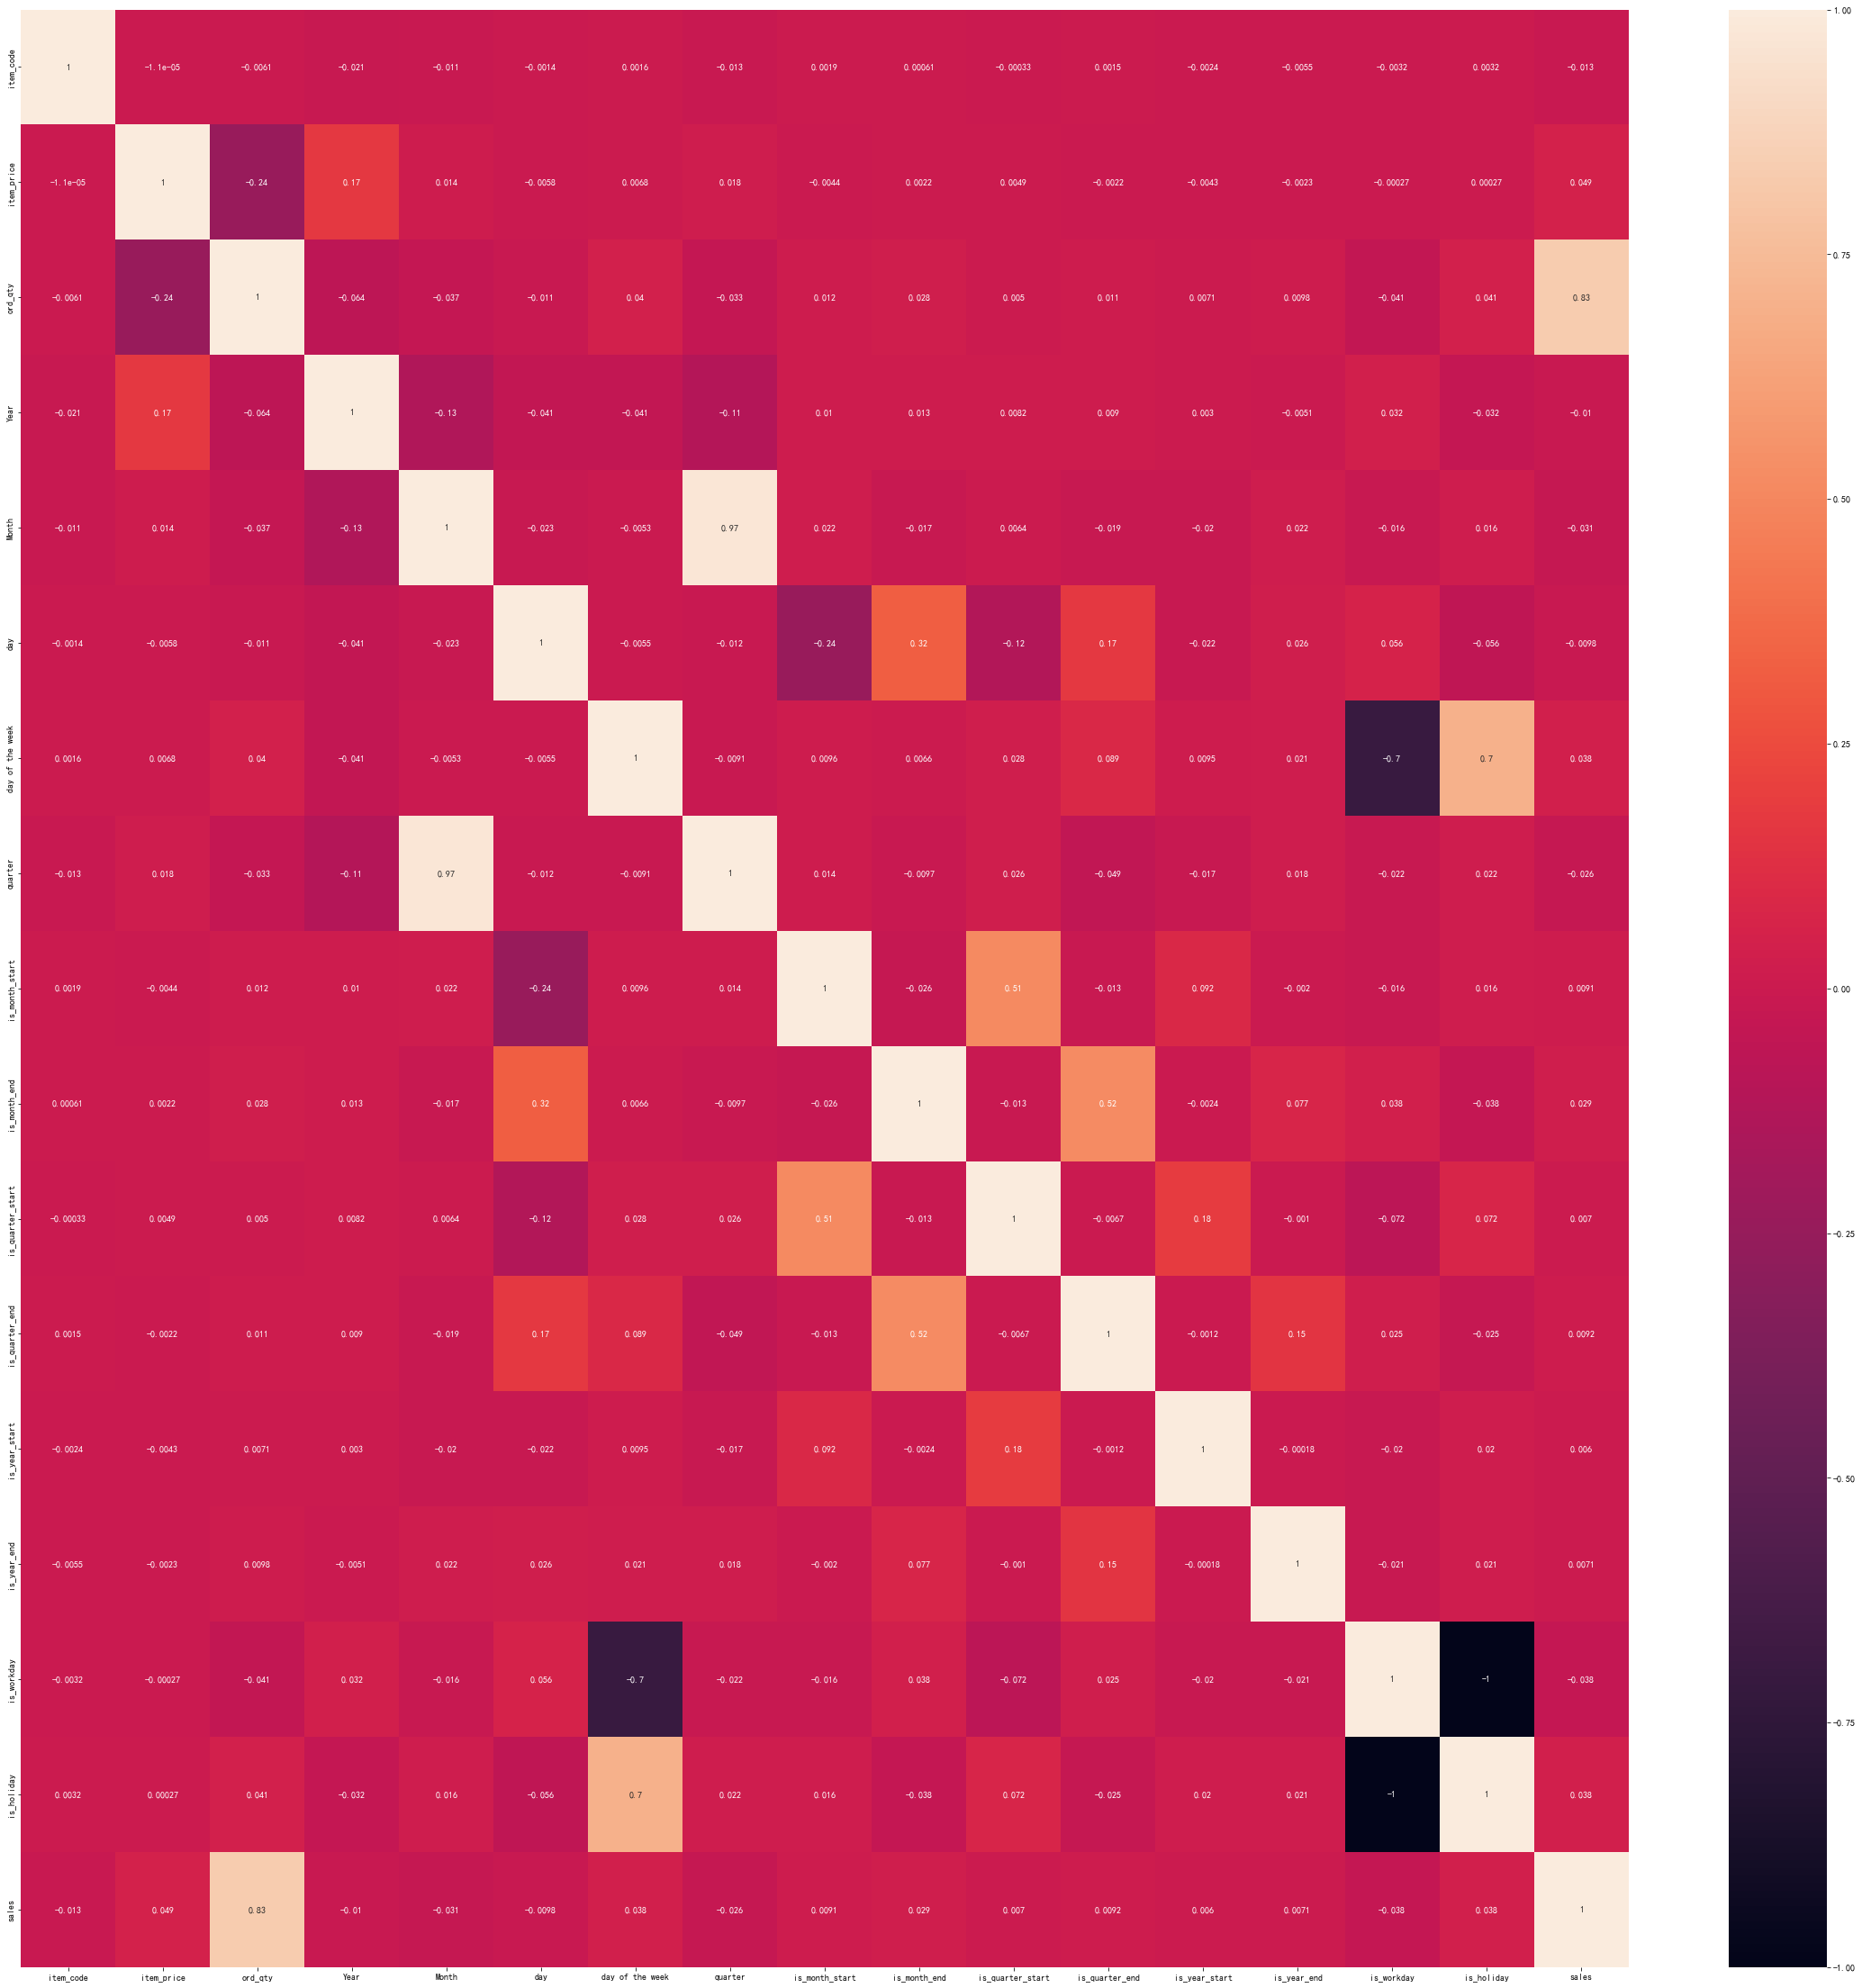

In [119]:
a = sales_data.drop(["sales_chan_name"],axis=1)
plt.figure(figsize = (40,40))
corr_matrix = a.corr()
sns.heatmap(corr_matrix, annot = True)